In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import zipfile
import os

# اسم الملف بعد الرفع
zip_path = "Teeth_Dataset.zip"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Teeth_Dataset")

# التحقق
os.listdir("/content/Teeth_Dataset")


['Teeth_Dataset']

In [3]:
data_train_path = '/content/Teeth_Dataset/Teeth_Dataset/Training'
data_test_path = '/content/Teeth_Dataset/Teeth_Dataset/Testing'
data_val_path = '/content/Teeth_Dataset/Teeth_Dataset/Validation'

In [4]:
img_width = 256
img_height =256

In [5]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 3087 files belonging to 7 classes.


In [13]:
data_diseases = data_train.class_names
data_diseases

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

In [14]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_height,img_width),
    batch_size=32,
    shuffle=False,
    validation_split=False)

Found 1028 files belonging to 7 classes.


In [15]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 1028 files belonging to 7 classes.


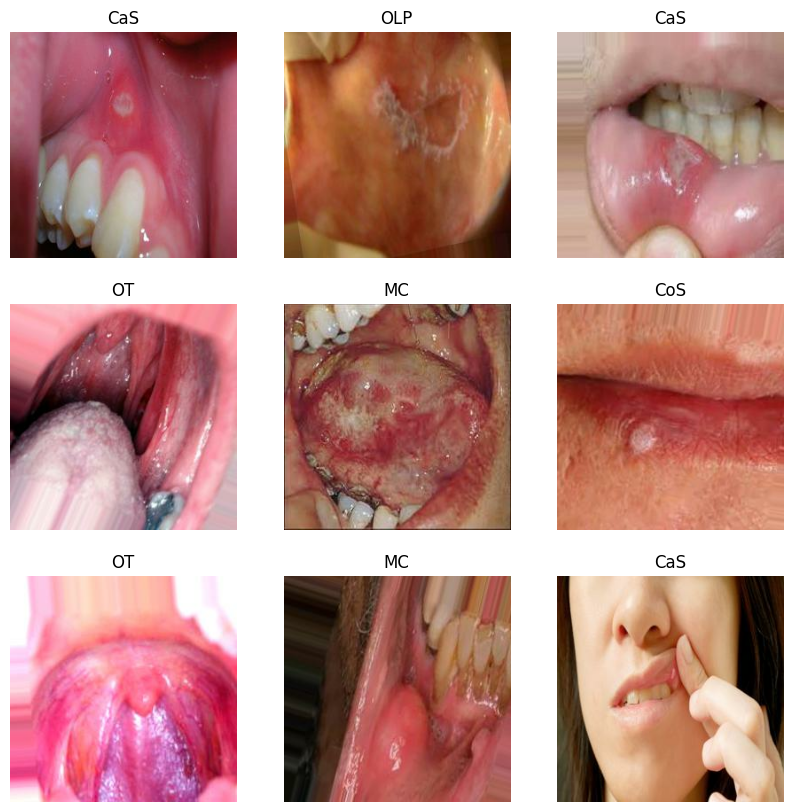

In [17]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_diseases[labels[i]])
        plt.axis('off')

In [19]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
# Data Augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [59]:
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dropout(0.3),
    layers.Dense(len(data_diseases))

])

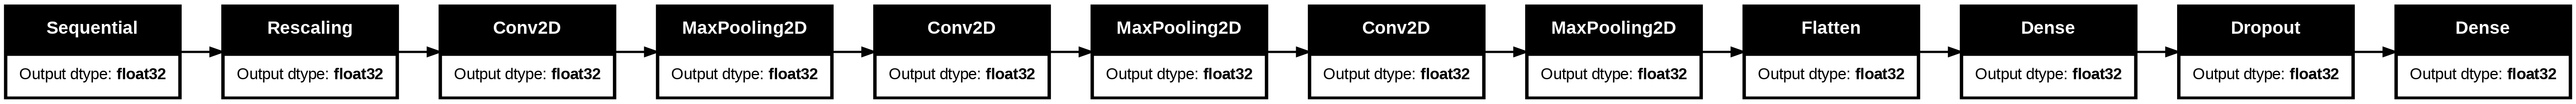

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model, rankdir='LR', show_dtype=True)

In [61]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,223 (32.09 MB)

 Trainable params: 8,413,223 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [63]:
# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [64]:
epochs_size = 50
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size,callbacks=[early_stop])

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.1908 - loss: 4.7532 - val_accuracy: 0.2646 - val_loss: 1.8352
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3064 - loss: 1.7705 - val_accuracy: 0.3444 - val_loss: 1.6706
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3522 - loss: 1.6552 - val_accuracy: 0.3949 - val_loss: 1.6353
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4014 - loss: 1.5872 - val_accuracy: 0.4251 - val_loss: 1.4678
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4601 - loss: 1.4446 - val_accuracy: 0.4465 - val_loss: 1.4580
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4577 - loss: 1.4294 - val_accuracy: 0.5253 - val_loss: 1.2952
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5210 - loss: 1.2862 - val_accuracy: 0.5438 - val_loss: 1.2410
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5143 - loss: 1.2800 - val_accuracy: 0.5233 - v

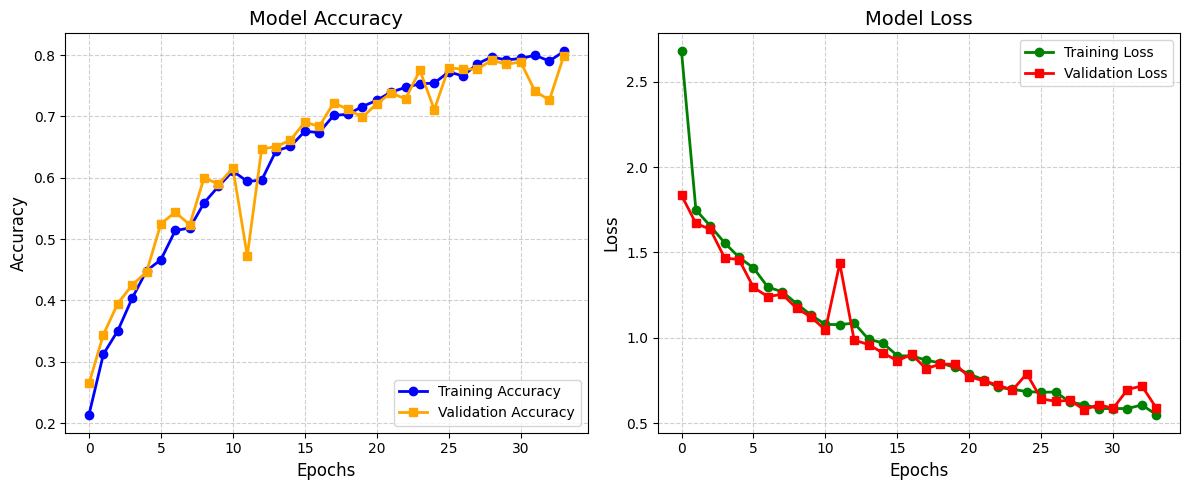

In [67]:
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2, marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2, marker='s')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color='green', linewidth=2, marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='red', linewidth=2, marker='s')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [68]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(data_test, verbose=2)

print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


33/33 - 1s - 18ms/step - accuracy: 0.7831 - loss: 0.6529
✅ Test Accuracy: 78.31%
✅ Test Loss: 0.6529


In [72]:
#Get predictions
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # اختار الكلاس بأعلى احتمال

# Get true labels
y_true = np.concatenate([y for x, y in data_test], axis=0)

#Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=data_diseases))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:

              precision    recall  f1-score   support

         CaS       0.77      0.76      0.76       160
         CoS       0.86      0.95      0.90       149
         Gum       0.77      0.80      0.78       120
          MC       0.85      0.72      0.78       180
          OC       0.63      0.78      0.70       108
         OLP       0.77      0.72      0.75       180
          OT       0.80      0.79      0.80       131

    accuracy                           0.78      1028
   macro avg       0.78      0.79      0.78      1028
weighted avg       0.79      0.78      0.78      1028



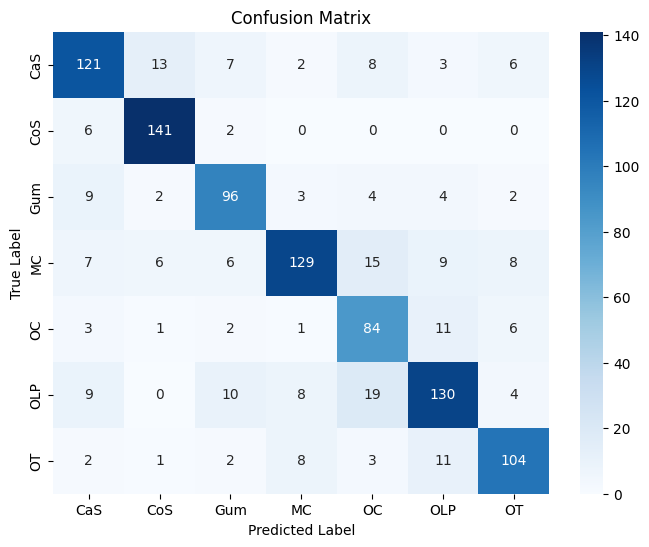

In [74]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=data_diseases,
            yticklabels=data_diseases)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [78]:
img_path = "/content/R.jpeg"
img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


In [81]:
predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0]).numpy()

predicted_class = np.argmax(score)
predicted_label = data_diseases[predicted_class]
predicted_prob = score[predicted_class]

print(f"Predicted Class: {predicted_label} ({predicted_prob:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Class: OLP (65.66%)


In [82]:
model.save('teeth classification.keras')